# Deep Q-Network for Atari Breakout.

In this assignment you are required to implement a Deep Q-Network agent, for the Atari game Breakout.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [ ]:
!pip install setuptools==65.5.0 "wheel<0.40.0"
!pip install stable-baselines3[extra] ale-py==0.7.4 gym==0.21.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay
!pip install utils

In [2]:
import os
import random
import numpy as np
import torch
import gym
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
#     !apt-get -qq install -y xvfb
#     os.environ['DISPLAY'] = ':1'
# 
# display = Display(visible=0, size=(400, 300))
# display.start()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Breakout

This is an environment emulating the Atari game *Breakout*. The goal is to break all the bricks in the wall without letting the ball touch the floor. You have 5 lives and get points more points for higher brick than for the lower ones.

The observation is an image with dimensions (210, 160, 3).

There are 4 actions defined as NOOP, FIRE, LEFT and RIGHT.

See full description [here](https://www.gymlibrary.dev/environments/atari/breakout/).




observation dim (210, 160, 3) number of actions 4


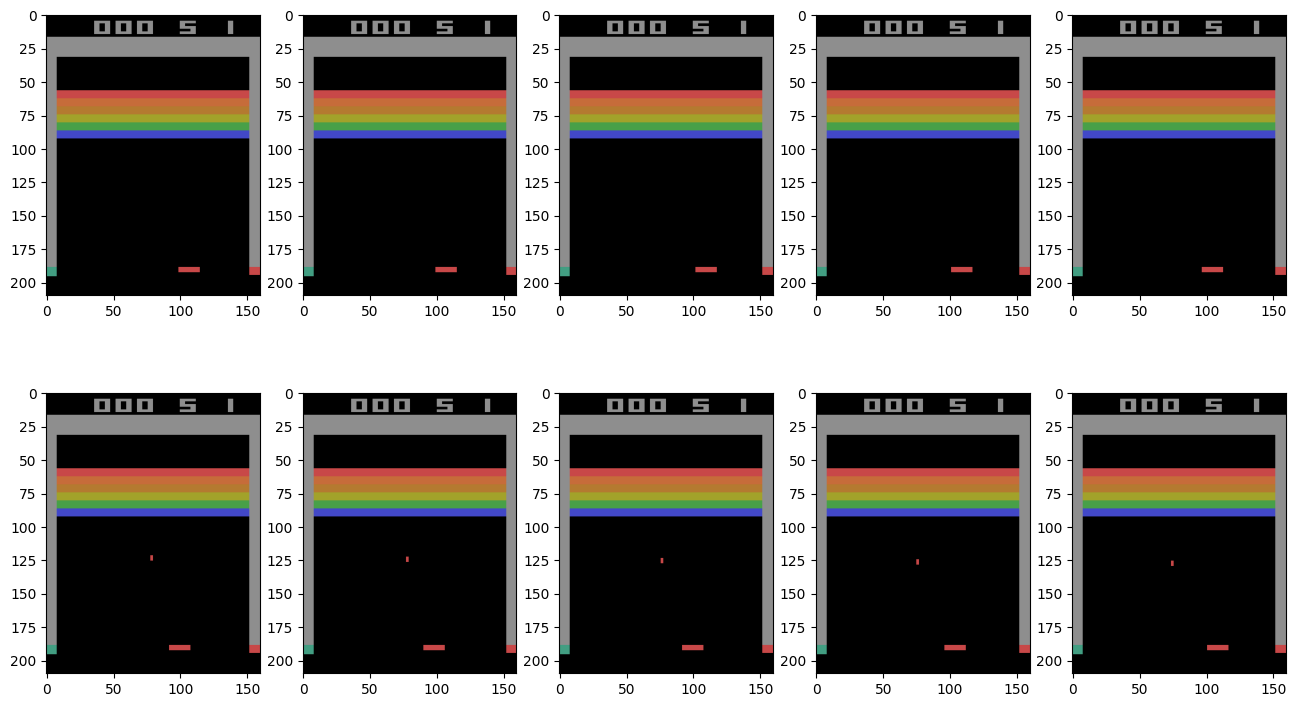

In [3]:
ENV_NAME = "BreakoutNoFrameskip-v4"
env = gym.make(ENV_NAME)
obs = env.reset()

n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)


n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        #ax.imshow(obs)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Wrappers

In order to make the environment more suitable for RL training, we make the following updates to the environment, using environment wrappers:
1. Preprocess the images to contain only the relevant part of the image, converted to grayscale. The raw images are large and we can do with 64x64 images.
2. Concatenate the 4 previous images (in order to capture dynamics)
3. Start the fire action automatically when starting the episode
4. Repeat the same action for 4 time steps
5. Output the maximum values of the last 2 frames per pixel (in order to prevent blinking)
6. Ouput a "done" signal every time a life is reduced but only reset the environment when all lives are gone
7. Bin the rewards to the values {-1, 0, 1}




In [4]:
from gym.core import Wrapper
from gym.spaces.box import Box
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def observation(self, img):
        """what happens to each observation"""

        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[34:-16, 8:-8, :]
        img = cv2.resize(img, self.img_size[1:])
        img = (img*np.array([[[0.8, .1, .1]]])).sum(-1, keepdims=True)  # grayscale with more weight for red (accelerates training)
        img = img.astype('float32') / 255.
        return img.transpose((2, 0, 1))

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,) + env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = ClipRewardEnv(env)

    # This wrapper preprocesses observations
    env = PreprocessAtariObs(env)
    return env

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)


def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

## Check observations under wrappers

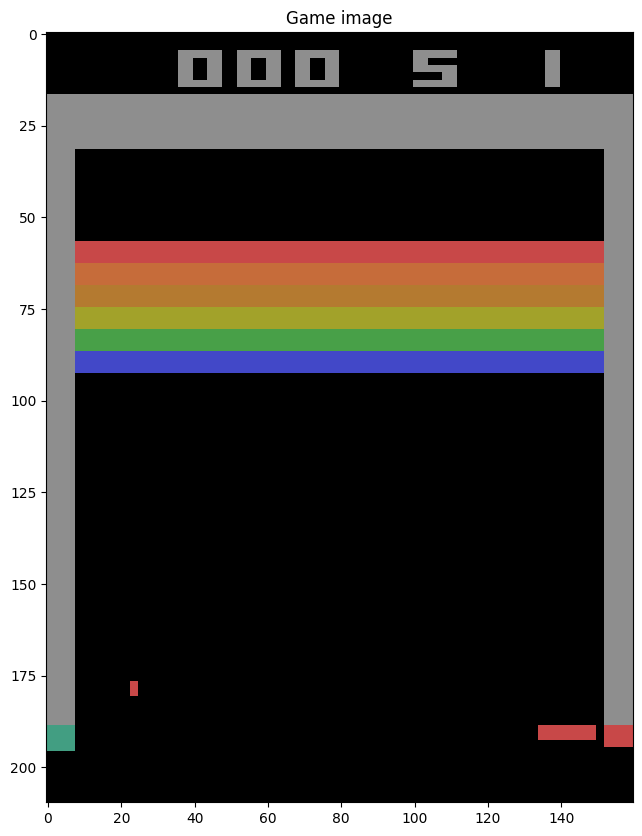

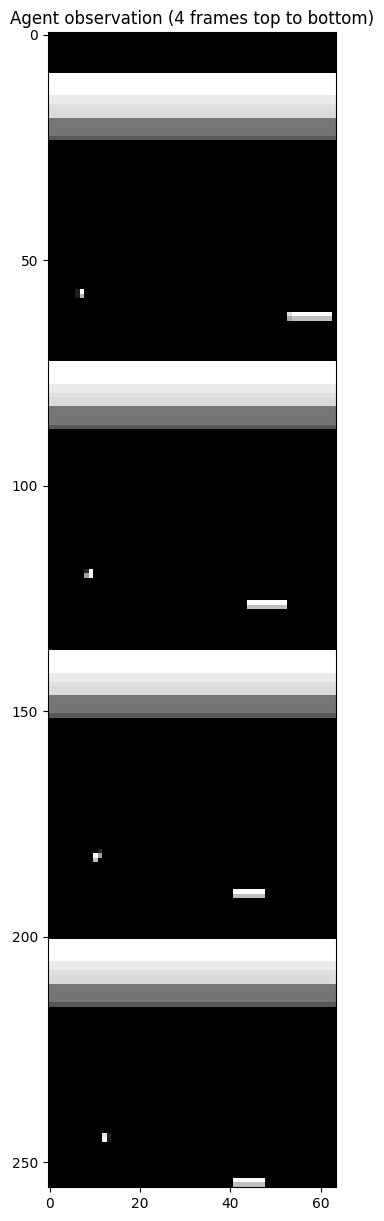

In [5]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(obs.reshape([-1, state_shape[2]]), cmap='gray')
plt.show()

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes.

In [6]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,))

In [7]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

agent = RandomAgent(n_actions)
mean_reward = evaluate(env, agent, greedy=True, n_games=5)

## Video generation

In [13]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

n_games = 1 # how many games to record

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games=3, greedy=False) for _ in range(10)]


DependencyNotInstalled: Found neither the ffmpeg nor avconv executables. On OS X, you can install ffmpeg via `brew install ffmpeg`. On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`. Alternatively, please install imageio-ffmpeg with `pip install imageio-ffmpeg`

In [14]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

IndexError: list index out of range

## Assignment

Implement a DQN agent that contains:
1. A neural network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.

In [8]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        self.network = nn.Sequential(
        nn.Conv2d(in_channels=state_shape[0], out_channels=16, kernel_size=3, stride=2)
        ,nn.ReLU()
        ,nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2)
        ,nn.ReLU()
        ,nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        ,nn.ReLU()
        ,nn.Flatten()
        ,nn.Linear(in_features=conv2d_size_out(conv2d_size_out(conv2d_size_out(64,3,2), 3, 2), 3, 2)**2 * 64, out_features=256)
        ,nn.ReLU()
        ,nn.Linear(in_features=256, out_features=n_actions)
        )
    def forward(self, states):
        return self.network(states)

    def get_qvalues(self, states):
        values = self.forward(torch.tensor(states, device=next(self.parameters()).device, dtype=torch.float))
        return values.data.cpu().numpy()

    def sample_actions(self, qvalues):
        size, actions = qvalues.shape
        choice = np.random.choice([0, 1], size, p=[1-self.epsilon, self.epsilon])
        return np.where(choice, np.random.choice(actions, size=size), qvalues.argmax(axis=-1))

def conv2d_size_out(size, kernel_size, stride):
    output_size = (size - kernel_size) // stride + 1
    return output_size

In [9]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

In [10]:
import numpy as np
import random

class ReplayBuffer(object):
    def __init__(self, size):
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t = []
        actions = []
        rewards = []
        obses_tp1 = []
        dones = []

        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)

        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)



In [11]:
def env_step(state, agent, env, exp_replay, n_steps=1):
    reward = 0
    for t in range(n_steps):
        qvalues = agent.get_qvalues([state])
        action = agent.sample_actions(qvalues)[0]
        next_state, current_reward, done, _ = env.step(action)

        exp_replay.add(state, action, current_reward, next_state, done)
        reward += current_reward
        if done:
            state = env.reset()
        else:
            state = next_state

    return state

In [12]:
def td_loss(states, actions, rewards, next_states, is_done,agent, target_network, gamma=0.99, check_shapes=False, device=device):
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    done = torch.tensor(is_done.astype('float32'),device=device,dtype=torch.float)
    predicted_qvalues = agent(torch.tensor(states, device=device, dtype=torch.float))
    predicted_next_qvalues = target_network(torch.tensor(next_states, device=device, dtype=torch.float))
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]
    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0]
    target_qvalues_for_actions = torch.tensor(rewards, device=device, dtype=torch.float) + gamma * (next_state_values * (1 - done))
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)
    return loss

In [13]:
def linear_decay(init_val, final_val, current_step, total_steps):
    decay_rate = (init_val - final_val) / total_steps
    decayed_value = max(final_val, init_val - decay_rate * current_step)
    return decayed_value

In [30]:
random.seed(444)
np.random.seed(444)
torch.manual_seed(444)
env = make_env(444)
state_shape = env.observation_space.shape
state = env.reset()
agent = DQNAgent(state_shape, 4, epsilon=1).to(device)
target_network = DQNAgent(state_shape, 4).to(device)
target_network.load_state_dict(agent.state_dict())
exp_replay = ReplayBuffer(10**4)
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)
reward_history = []
reward_mean = []
step = 0
total_steps = 2 *(10**6)
decay_steps = 10**6

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import utils
import os

for i in range(100):
    env_step(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break

model_save_path = "saved_models/"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)

state = env.reset()
for step in range(0, total_steps):

    new_epsilon = linear_decay(1, 0.1, step, decay_steps)

    agent.epsilon = new_epsilon

    state = env_step(state, agent, env, exp_replay, 1)

    obs, actions, rewards, next_obs, is_done = exp_replay.sample(16)
    reward_history.append(rewards)

    loss = td_loss(obs, actions, rewards, next_obs, is_done,agent, target_network,gamma=0.99, check_shapes=False, device=device)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if step % 10000 == 0:
        # Save the model
        model_filename = f"model_step_{step}.pt"
        torch.save(agent.state_dict(), os.path.join(model_save_path, model_filename))
        
    if step % 5000 == 0:
        target_network.load_state_dict(agent.state_dict())
        reward_mean.append(evaluate(make_env(clip_rewards=True, seed=step), agent, n_games=3 * 5, greedy=True))

    print("Current Step = ", step)



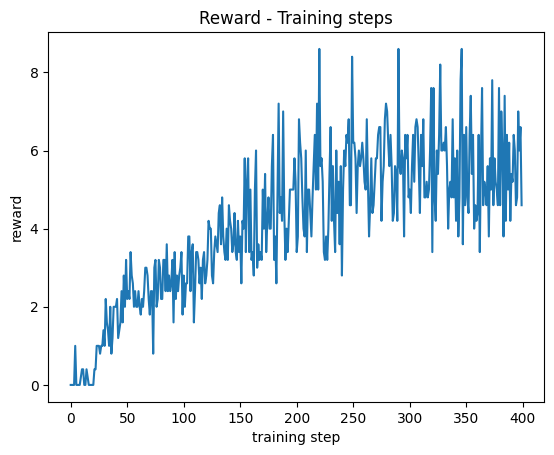

In [37]:
plt.plot(reward_mean)
plt.xlabel('training step')
plt.ylabel('reward')
plt.title('Reward - Training steps')
plt.show()

In [ ]:

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
import shutil

from IPython.display import HTML

shutil.rmtree("videos", ignore_errors=True)
os.makedirs("videos", exist_ok=True)
n_games = 30
with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games = 30, greedy=True, t_max = 10 * 1000)]

In [ ]:

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
import shutil

from IPython.display import HTML

shutil.rmtree("videos", ignore_errors=True)
os.makedirs("videos", exist_ok=True)
n_games = 30
with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(make_env(clip_rewards=False, seed=9),agent, n_games=30, greedy=True, t_max=10 * 1000) * 5]

In [ ]:
# Show video
video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[1]  # You can also try other indices (if n_games > 1)

if 'google.colab' in sys.modules:
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

# Display video
HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))